In [19]:
train_on = ['reman', 'gne', 'electoral_tweets'][1]

# import

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, Callback
from transformers import RobertaConfig, TFRobertaModel
import tensorflow as tf
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import *
from keras.optimizers import *

# read data

In [2]:
df = pd.read_json("emotion-rl-corpora-DO-NOT-SHARE.jsonl", lines = True)

In [3]:
# remove unused columns
df = df.drop(columns=['id', 'text', 'emotions', 'meta', 'steps', 'tags', 'annotation-offsets', 'split', 'extra'])
# make json to column
df = df.join(df['annotations'].apply(pd.Series))
# remove created unused columns
df = df.drop(columns=['cue-joy', 'cue-sadness', 'cue-anger', 'cue-other', 'cue-disgust', 'cue-trust', 'cue-anticipation', 'cue-surprise', 'cue-fear', 'cue'])
# remove unused columns
df = df.drop(columns=['annotations', 'cause', 'experiencer'])
# drop nan-rows
df = df.dropna()

# preprocessing

In [4]:
print("maximum sentence length", len(max(df["tokens"], key=len)))

maximum sentence length 121


In [5]:
# set maximum sentence length
maxlen = 100

In [6]:
df['dataset'].unique()

array(['reman', 'gne', 'electoral_tweets'], dtype=object)

In [7]:
data_source = df.loc[(df['dataset'] == train_on)]

In [8]:
tag2idx = {t:i for i,t in enumerate(['O', 'B', 'I'])}
idx2tag = {i:t for i,t in enumerate(['O', 'B', 'I'])}

In [9]:
X = data_source["tokens"].to_numpy()
y = data_source["target"].to_numpy()

In [10]:
#X = pad_sequences(X, maxlen, value="__PADWORD__", dtype=object, padding='post')

In [11]:
# pad labels to same lenght
y = pad_sequences(y, maxlen, value='O', dtype=object, padding='post')
y = np.array([[tag2idx[w] for w in s] for s in y])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420)

In [13]:
# define tokenizer
from transformers import  RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True, add_special_tokens=True,
                                              max_length=maxlen, pad_to_max_length=True)

In [14]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, padding='max_length', 
                                             return_attention_mask=True, return_token_type_ids=True, truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [15]:
input_ids, input_masks, _ = tokenize(X_train, tokenizer)
test_input_ids, test_input_masks, _ = tokenize(X_test, tokenizer)

# train

In [16]:
config = RobertaConfig.from_pretrained("roberta-base", dropout=0.2, attention_dropout=0.2, output_hidden_states=True)
transformer_model = TFRobertaModel.from_pretrained('roberta-base', config = config)
transformer_model.trainable = False

input_ids_in = Input(shape=(maxlen,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(maxlen,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
#cls_token = embedding_layer[:,0,:]
x = Bidirectional(LSTM(units=256, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding_layer)
x_rnn = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(3, activation="softmax"))(x)

model = Model(inputs=[input_ids_in, input_masks_in], outputs = out)
optimizer = Adam(learning_rate=0.0005)
#optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

history = model.fit((input_ids, input_masks),
                    y_train,
                    epochs=2, # 10
                    batch_size=200,
                    validation_data=((test_input_ids, test_input_masks),y_test),
                    callbacks=[
                        ReduceLROnPlateau(monitor='accuracy',
                                          patience=10,
                                          verbose=1,
                                          factor=0.9,
                                          min_lr=0.00001)
                    ])

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 100, 768), ( 124645632   input_token[0][0]  

# history

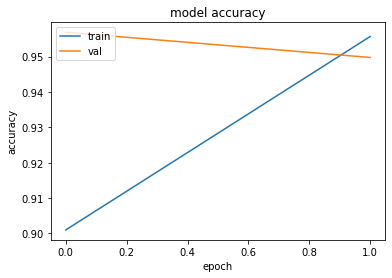

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)

# plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("roberta-" + train_on + "-history.png",bbox_inches='tight',transparent=False, pad_inches=0.1,  dpi=300)
plt.show()

# evaluation

In [ ]:
# old function
def nn_predict(texts):
    lst = []
    for row in texts:
        seq = tokenizer.texts_to_sequences([row])
        padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
        lst.append(padded_seq)
    model_output = model.predict(np.vstack(lst))
    return np.argmax(model_output, axis=1)

In [21]:
# select correct dataset
data_source = df.loc[(df['dataset'] != train_on)]
eval_on = data_source['dataset'].unique()

In [ ]:
# make evaluation on data and save everything to graphs

In [ ]:
X = data_source["tokens"].to_numpy()
y = data_source["target"].to_numpy()

In [ ]:
y = pad_sequences(y, maxlen, value='O', dtype=object, padding='post')
y = np.array([[tag2idx[w] for w in s] for s in y])

In [ ]:
input_ids, input_masks, _ = tokenize(X, tokenizer)
test_input_ids, test_input_masks, _ = tokenize(X, tokenizer)